<a href="https://colab.research.google.com/github/paulomarc49/ETo_climate/blob/main/ETo_weather_tunning_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Run if have access to drive:

from google.colab import drive
drive.mount('/content/drive')
numpy_data = np.load('/content/drive/MyDrive/ETo/data_april_2024.npy')

Mounted at /content/drive


In [3]:
# Run if no access to drive and want to download the file:

import gdown
gdown.download(f'https://drive.google.com/uc?id=1jrMMuLAVbsdhxTm8icgoH0tOLMRpw22n', 'data_april_2024.npy', quiet=False)
numpy_data = np.load('data_april_2024.npy')

Downloading...
From (original): https://drive.google.com/uc?id=1jrMMuLAVbsdhxTm8icgoH0tOLMRpw22n
From (redirected): https://drive.google.com/uc?id=1jrMMuLAVbsdhxTm8icgoH0tOLMRpw22n&confirm=t&uuid=5caa330d-a162-42a6-84a0-0db370ac6dfe
To: /content/data_april_2024.npy
100%|██████████| 674M/674M [00:03<00:00, 201MB/s]


In [4]:
# Shape of converted data from April 2024

print("Shape of the original data: ", numpy_data.shape)

# Input data is an array of three dimentions with the shape: ( d * y, x, 8 variables * 24 hours ) d: number of days,  y: Pixel "Y", x: Pixel "X", 8 * 24 number of variables per 24 hours

numpy_data = numpy_data.reshape(-1, 192)
numpy_data = numpy_data.astype(np.float16)
print("Shape of the flattened input data: ", numpy_data.shape)

Shape of the original data:  (5130, 171, 192)
Shape of the flattened input data:  (877230, 192)


## Implementation with sci-kit learn SOM

In [6]:
!pip install sklearn-som

import  warnings
from    sklearn.base             import BaseEstimator, ClusterMixin
from    sklearn_som.som          import SOM as SklearnSOM

warnings.filterwarnings("ignore")

In [7]:
#Customization of sci-kit learn SOM

class CustomSOM(BaseEstimator, ClusterMixin):
    def __init__(self, m=1, n=1, dim=1, sigma=1, lr=1, max_iter=1, random_state=None):
        self.m = m
        self.n = n
        self.dim = dim
        self.sigma = sigma
        self.lr = lr
        self.max_iter = max_iter
        self.random_state = random_state
        self.model_ = None

    def fit(self, X, y=None):
        self.model_ = SklearnSOM(m=self.m, n=self.n, dim=self.dim, lr=self.lr, max_iter=self.max_iter, random_state=self.random_state)
        self.model_.fit(X)
        return self

    def predict(self, X):
        return self.model_.predict(X)

    def transform(self, X):
        return self.model_.transform(X)

    def score(self, X, y=None):
        distancias_punto_centroide = self.transform(X)
        distorsion_total = 0
        for i in range(len(distancias_punto_centroide)):
            distancias_minimas_cuadradas = (np.min(distancias_punto_centroide[i]))**2
            distorsion_total += distancias_minimas_cuadradas
        return distorsion_total

In [9]:
from joblib import Parallel, delayed
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define "k" values to test
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
distortions = []

# Function to compute distortion for a given k
def compute_distortion(k, data):
    model_SOM_2 = Pipeline([
        ('scal', StandardScaler()),
        ('som', CustomSOM(m=k, n=2, dim=192, lr=1.5, max_iter=90, random_state=42))
    ])
    # Transform the data and fit the SOM
    SOM_train_inicial = model_SOM_2[:-1].fit_transform(data)
    SOM_train = model_SOM_2[-1].fit(SOM_train_inicial)
    # Calculate distortion
    distortion_SOM_train = model_SOM_2.named_steps['som'].score(SOM_train_inicial)
    return distortion_SOM_train

# Run the computations in parallel
distortions = Parallel(n_jobs=5)(delayed(compute_distortion)(k, numpy_data) for k in k_values)

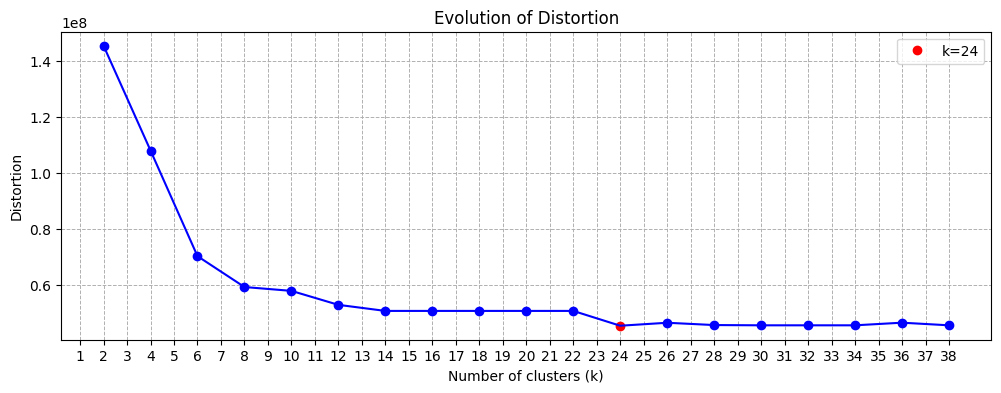

In [11]:
# Plot the distortion in terms of k
plt.figure(figsize=(12, 4))

# Define x-values and plot all points except the one at x = 36
x_values = range(2, 39, 2)
for x, y in zip(x_values, distortions):
    if x == 24:
        plt.plot(x, y, 'ro', label='k=24')  # Highlighting the point at k=36
    else:
        plt.plot(x, y, 'bo')  # All other points

# Connect the points with a line
plt.plot(x_values, distortions, 'b-')
plt.xticks(range(1, 39))
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion')
plt.title('Evolution of Distortion')
plt.legend()

# Show plot and save it in high definition
plt.savefig("distortion_plot_hd.png", dpi=300, bbox_inches='tight')
plt.show()
